# Bước 3: Apriori Modeling for Association Rules

Notebook này sử dụng ma trận `basket_bool` (được chuẩn bị ở bước 02) để:

- Khai thác **tập mục phổ biến** (frequent itemsets) bằng thuật toán **Apriori**
- Sinh **luật kết hợp** (association rules) với các chỉ số: `support`, `confidence`, `lift`
- Lọc luật theo các ngưỡng do người dùng cấu hình
- Trực quan hoá một số nhóm luật tiêu biểu phục vụ storytelling & phân tích kinh doanh
- Lưu kết quả luật đã lọc ra file `.csv` để sử dụng trong báo cáo, dashboard hoặc các bước phân tích tiếp theo

Notebook được thiết kế theo kiểu *parameterized* để dễ dàng tích hợp với **papermill**, cho phép chạy tự động với các ngưỡng support/confidence khác nhau mà không cần sửa code.


In [ ]:
# PARAMETERS (for papermill)

# Đường dẫn tới basket_bool được tạo từ Notebook 02
BASKET_BOOL_PATH = "data/processed/basket_bool.parquet"

# Đường dẫn lưu file luật kết hợp sau khi lọc
RULES_OUTPUT_PATH = "data/processed/rules_apriori_filtered.csv"

# ==============================
# Tham số cho Apriori (AN TOÀN)
# ==============================

# ⬆ Tăng support để giảm số tập mục
MIN_SUPPORT = 0.03      # KHÔNG dùng 0.01 (rất dễ treo)
MAX_LEN = 2             # Giới hạn itemset tối đa 2 sản phẩm

# ==============================
# Tham số sinh luật
# ==============================

METRIC = "lift"
MIN_THRESHOLD = 1.2

# ==============================
# Lọc luật sau khi generate
# ==============================

FILTER_MIN_SUPPORT = 0.03
FILTER_MIN_CONF = 0.4
FILTER_MIN_LIFT = 1.3
FILTER_MAX_ANTECEDENTS = 1
FILTER_MAX_CONSEQUENTS = 1

# ==============================
# Trực quan hóa
# ==============================

TOP_N_RULES = 15

PLOT_TOP_LIFT = True
PLOT_TOP_CONF = True
PLOT_SCATTER = True

# ❌ TẮT NETWORK GRAPH (rất nặng)
PLOT_NETWORK = False

# ❌ TẮT Plotly (dễ treo VS Code)
PLOT_PLOTLY_SCATTER = False


## Set up

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys

# Determine correct project root
cwd = os.getcwd()
if os.path.basename(cwd) == "notebooks":
    project_root = os.path.abspath("..")
else:
    project_root = cwd

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Biểu đồ tương tác HTML
import plotly.express as px

from apriori_library import AssociationRulesMiner  # class trong library của bạn


## Thiết lập style vẽ biểu đồ 

In [3]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12


## Tải basket_bool

In [4]:
# Đọc ma trận basket_bool từ bước 2
basket_bool = pd.read_parquet(BASKET_BOOL_PATH)

print("=== Thông tin basket_bool ===")
print(f"- Số hoá đơn (rows): {basket_bool.shape[0]:,}")
print(f"- Số sản phẩm (columns): {basket_bool.shape[1]:,}")
print(f"- Tỷ lệ ô = 1 (có mua): {basket_bool.values.mean():.4f}")

basket_bool.head()


=== Thông tin basket_bool ===
- Số hoá đơn (rows): 18,021
- Số sản phẩm (columns): 4,007
- Tỷ lệ ô = 1 (có mua): 0.0066


,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Khai thác tập phổ biến bằng thuật toán Apriori

In [5]:
# Khởi tạo Apriori miner
miner = AssociationRulesMiner(basket_bool=basket_bool)

start_time = time.time()
frequent_itemsets_ap = miner.mine_frequent_itemsets(
    min_support=MIN_SUPPORT,
    max_len=MAX_LEN,
    use_colnames=True,
)
elapsed_time = time.time() - start_time

print("=== Kết quả khai thác tập mục phổ biến (Apriori) ===")
print(f"- Thời gian chạy: {elapsed_time:.2f} giây")
print(f"- Số tập mục phổ biến thu được: {len(frequent_itemsets_ap):,}")

frequent_itemsets_ap.head(10)


=== Kết quả khai thác tập mục phổ biến (Apriori) ===
- Thời gian chạy: 0.42 giây
- Số tập mục phổ biến thu được: 145


,support,itemsets
128,0.119971,(WHITE HANGING HEART T-LIGHT HOLDER)
55,0.107375,(JUMBO BAG RED RETROSPOT)
102,0.093502,(REGENCY CAKESTAND 3 TIER)
90,0.088397,(PARTY BUNTING)
73,0.077243,(LUNCH BAG RED RETROSPOT)
8,0.076078,(ASSORTED COLOUR BIRD ORNAMENT)
110,0.068864,(SET OF 3 CAKE TINS PANTRY DESIGN )
80,0.067643,(NATURAL SLATE HEART CHALKBOARD )
67,0.067477,(LUNCH BAG BLACK SKULL.)
37,0.064591,(HEART OF WICKER SMALL)


## Sinh luật kết hợp từ tập mục phổ biến

In [6]:
rules_ap = miner.generate_rules(
    metric=METRIC,
    min_threshold=MIN_THRESHOLD,
)

# Thêm cột dạng chuỗi dễ đọc
rules_ap = miner.add_readable_rule_str()

print("=== Một vài luật kết hợp đầu tiên (chưa lọc) ===")
cols_preview = [
    "antecedents_str",
    "consequents_str",
    "support",
    "confidence",
    "lift",
]
rules_ap[cols_preview].head(10)


=== Một vài luật kết hợp đầu tiên (chưa lọc) ===


,antecedents_str,consequents_str,support,confidence,lift
10,GREEN REGENCY TEACUP AND SAUCER,PINK REGENCY TEACUP AND SAUCER,0.031963,0.618026,15.865302
11,PINK REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER,0.031963,0.820513,15.865302
19,PINK REGENCY TEACUP AND SAUCER,ROSES REGENCY TEACUP AND SAUCER,0.030242,0.776353,14.634584
18,ROSES REGENCY TEACUP AND SAUCER,PINK REGENCY TEACUP AND SAUCER,0.030242,0.570084,14.634584
21,GARDENERS KNEELING PAD CUP OF TEA,GARDENERS KNEELING PAD KEEP CALM,0.030021,0.721333,14.475666
20,GARDENERS KNEELING PAD KEEP CALM,GARDENERS KNEELING PAD CUP OF TEA,0.030021,0.602450,14.475666
2,GREEN REGENCY TEACUP AND SAUCER,ROSES REGENCY TEACUP AND SAUCER,0.038844,0.751073,14.158040
3,ROSES REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER,0.038844,0.732218,14.158040
14,ALARM CLOCK BAKELIKE GREEN,ALARM CLOCK BAKELIKE RED,0.031241,0.642694,12.453752
15,ALARM CLOCK BAKELIKE RED,ALARM CLOCK BAKELIKE GREEN,0.031241,0.605376,12.453752


## Lọc các luật theo ngưỡng support/ confidence / lift

In [7]:
rules_filtered_ap = miner.filter_rules(
    min_support=FILTER_MIN_SUPPORT,
    min_confidence=FILTER_MIN_CONF,
    min_lift=FILTER_MIN_LIFT,
    max_len_antecedents=FILTER_MAX_ANTECEDENTS,
    max_len_consequents=FILTER_MAX_CONSEQUENTS,
)

print("=== Thống kê sau khi lọc luật ===")
print(f"- Tổng số luật ban đầu: {rules_ap.shape[0]:,}")
print(f"- Số luật sau khi lọc: {rules_filtered_ap.shape[0]:,}")

rules_filtered_ap[cols_preview].head(10)


=== Thống kê sau khi lọc luật ===
- Tổng số luật ban đầu: 22
- Số luật sau khi lọc: 18


,antecedents_str,consequents_str,support,confidence,lift
0,GREEN REGENCY TEACUP AND SAUCER,PINK REGENCY TEACUP AND SAUCER,0.031963,0.618026,15.865302
1,PINK REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER,0.031963,0.820513,15.865302
2,PINK REGENCY TEACUP AND SAUCER,ROSES REGENCY TEACUP AND SAUCER,0.030242,0.776353,14.634584
3,ROSES REGENCY TEACUP AND SAUCER,PINK REGENCY TEACUP AND SAUCER,0.030242,0.570084,14.634584
4,GARDENERS KNEELING PAD CUP OF TEA,GARDENERS KNEELING PAD KEEP CALM,0.030021,0.721333,14.475666
5,GARDENERS KNEELING PAD KEEP CALM,GARDENERS KNEELING PAD CUP OF TEA,0.030021,0.602450,14.475666
6,GREEN REGENCY TEACUP AND SAUCER,ROSES REGENCY TEACUP AND SAUCER,0.038844,0.751073,14.158040
7,ROSES REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER,0.038844,0.732218,14.158040
8,ALARM CLOCK BAKELIKE GREEN,ALARM CLOCK BAKELIKE RED,0.031241,0.642694,12.453752
9,ALARM CLOCK BAKELIKE RED,ALARM CLOCK BAKELIKE GREEN,0.031241,0.605376,12.453752


## Trực quan top các luật theo Lift

c:\HOCTAP\datamining\shopping_cart_analysis\venv\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\HOCTAP\datamining\shopping_cart_analysis\venv\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\HOCTAP\datamining\shopping_cart_analysis\venv\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


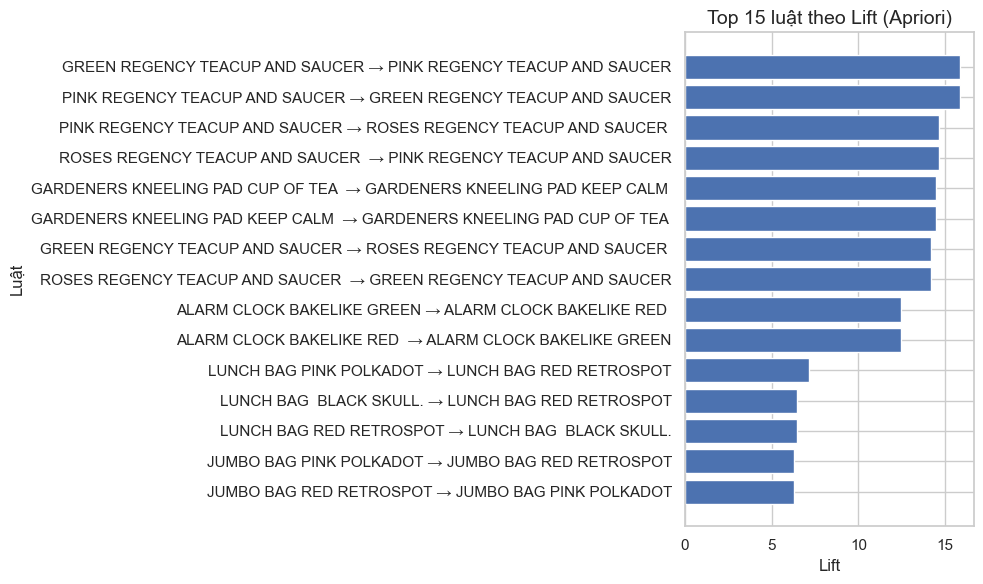

In [8]:
if PLOT_TOP_LIFT and not rules_filtered_ap.empty:
    top_rules_lift = rules_filtered_ap.sort_values(
        "lift", ascending=False
    ).head(TOP_N_RULES)

    plt.figure(figsize=(10, min(0.4 * len(top_rules_lift), 10)))
    plt.barh(top_rules_lift["rule_str"], top_rules_lift["lift"])
    plt.xlabel("Lift")
    plt.ylabel("Luật")
    plt.title(f"Top {len(top_rules_lift)} luật theo Lift (Apriori)")
    plt.gca().invert_yaxis()  # luật lớn nhất nằm trên
    plt.tight_layout()
    plt.show()
else:
    if rules_filtered_ap.empty:
        print("Không có luật nào sau khi lọc để vẽ top lift.")
    else:
        print("PLOT_TOP_LIFT = False, bỏ qua biểu đồ top lift.")


## Trực quan top luật theo confidence

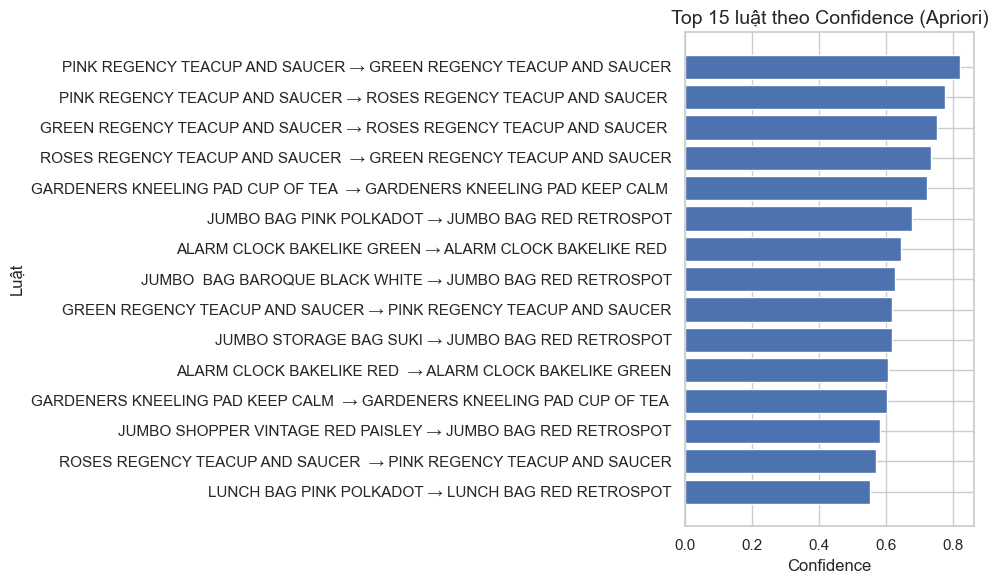

In [9]:
if PLOT_TOP_CONF and not rules_filtered_ap.empty:
    top_rules_conf = rules_filtered_ap.sort_values(
        "confidence", ascending=False
    ).head(TOP_N_RULES)

    plt.figure(figsize=(10, min(0.4 * len(top_rules_conf), 10)))
    plt.barh(top_rules_conf["rule_str"], top_rules_conf["confidence"])
    plt.xlabel("Confidence")
    plt.ylabel("Luật")
    plt.title(f"Top {len(top_rules_conf)} luật theo Confidence (Apriori)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    if rules_filtered_ap.empty:
        print("Không có luật nào sau khi lọc để vẽ top confidence.")
    else:
        print("PLOT_TOP_CONF = False, bỏ qua biểu đồ top confidence.")


Top luật kết hợp theo Confidence (Apriori)

Mô tả biểu đồ:
Biểu đồ dạng bar chart ngang thể hiện TOP N luật kết hợp có giá trị Confidence cao nhất được khai phá bằng thuật toán Apriori.
Trục hoành biểu diễn Confidence, trục tung biểu diễn các luật kết hợp (dạng A → B).

Ý nghĩa:

Confidence cho biết xác suất sản phẩm B được mua khi sản phẩm A đã được mua.

Các luật có confidence cao thể hiện mức độ tin cậy lớn của mối quan hệ giữa các sản phẩm.

Điều này cho thấy nếu khách hàng mua vế trái của luật thì khả năng cao họ cũng sẽ mua vế phải.

Nhận xét:

Những luật đứng đầu biểu đồ là các luật có khả năng dự đoán hành vi mua hàng tốt nhất.

Các luật này phù hợp để:

Đề xuất sản phẩm liên quan (recommendation)

Thiết kế chương trình bán kèm (up-selling, cross-selling)

Hỗ trợ ra quyết định trong chiến lược marketing

Kết luận:
Biểu đồ giúp doanh nghiệp xác định các mối quan hệ mua hàng đáng tin cậy, từ đó tối ưu hóa trải nghiệm khách hàng và tăng doanh thu.

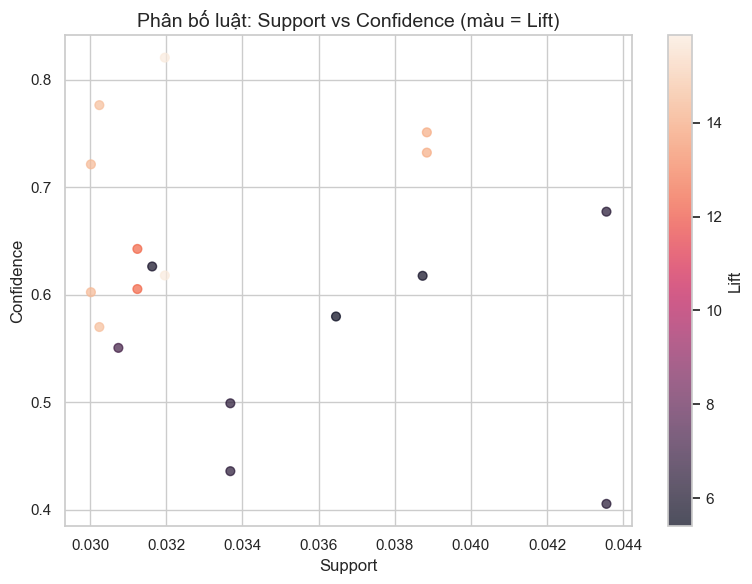

In [10]:
# Trực quan hoá quan hệ support vs confidence
if PLOT_SCATTER and not rules_filtered_ap.empty:
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        rules_filtered_ap["support"],
        rules_filtered_ap["confidence"],
        c=rules_filtered_ap["lift"],
        s=40,
        alpha=0.7,
    )
    plt.colorbar(scatter, label="Lift")
    plt.xlabel("Support")
    plt.ylabel("Confidence")
    plt.title("Phân bố luật: Support vs Confidence (màu = Lift)")
    plt.tight_layout()
    plt.show()
else:
    if rules_filtered_ap.empty:
        print("Không có luật nào sau khi lọc để vẽ scatter.")
    else:
        print("PLOT_SCATTER = False, bỏ qua biểu đồ scatter.")


Phân bố luật kết hợp theo Support và Confidence

Mô tả biểu đồ:
Biểu đồ dạng scatter plot thể hiện mối quan hệ giữa Support và Confidence của các luật kết hợp được khai phá bằng thuật toán Apriori.

Trục hoành biểu diễn Support

Trục tung biểu diễn Confidence

Màu sắc của các điểm biểu diễn giá trị Lift (Lift càng cao thì màu càng đậm)

Ý nghĩa:

Support phản ánh mức độ phổ biến của luật trong toàn bộ tập dữ liệu.

Confidence thể hiện độ tin cậy của luật, tức khả năng xảy ra của vế phải khi vế trái đã xảy ra.

Lift cho biết mức độ phụ thuộc giữa các sản phẩm; Lift > 1 thể hiện mối quan hệ mua kèm có ý nghĩa.

Nhận xét:

Các luật nằm ở góc trên bên phải (support cao, confidence cao) là những luật vừa phổ biến vừa đáng tin cậy.

Những điểm có màu đậm (lift cao) thể hiện các luật có mối liên hệ mạnh giữa các sản phẩm, rất có giá trị về mặt kinh doanh.

Các luật có confidence cao nhưng support thấp phản ánh những hành vi mua kèm đặc thù, phù hợp cho các chiến dịch nhắm mục tiêu.

Kết luận:
Biểu đồ giúp đánh giá tổng quan chất lượng các luật kết hợp, hỗ trợ lựa chọn những luật vừa có độ tin cậy cao vừa mang lại giá trị khai thác thực tiễn trong phân tích hành vi khách hàng.

In [11]:
## Tạo biểu đồ bằng HTML
if PLOT_PLOTLY_SCATTER and not rules_filtered_ap.empty:
    fig = px.scatter(
        rules_filtered_ap,
        x="support",
        y="confidence",
        color="lift",
        size="lift",
        hover_name="rule_str",
        title="Biểu đồ tương tác: Support vs Confidence (màu & kích thước = Lift)",
        labels={
            "support": "Support",
            "confidence": "Confidence",
            "lift": "Lift",
        },
    )
    fig.show()
else:
    if rules_filtered_ap.empty:
        print("Không có luật nào sau khi lọc để vẽ scatter Plotly.")
    else:
        print("PLOT_PLOTLY_SCATTER = False, bỏ qua biểu đồ Plotly.")


PLOT_PLOTLY_SCATTER = False, bỏ qua biểu đồ Plotly.


In [12]:
## Network các luật có lift cao
if PLOT_NETWORK and not rules_filtered_ap.empty:
    # Lấy một tập luật nhỏ để vẽ mạng (tránh quá rối)
    top_network_rules = rules_filtered_ap.sort_values(
        "lift", ascending=False
    ).head(min(TOP_N_RULES, 30))

    G = nx.DiGraph()

    for _, row in top_network_rules.iterrows():
        for a in row["antecedents"]:
            for c in row["consequents"]:
                # có thể gán weight theo lift
                G.add_edge(a, c, weight=row["lift"])

    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, k=0.5, seed=42)

    edges = G.edges(data=True)
    weights = [d["weight"] for (_, _, d) in edges] if edges else [1]

    nx.draw_networkx_nodes(G, pos, node_size=1500, node_color="lightblue")
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
    nx.draw_networkx_edges(
        G,
        pos,
        arrowstyle="->",
        arrowsize=15,
        width=[w / max(weights) * 2 for w in weights],
        edge_color="gray",
    )

    plt.title("Mạng lưới các luật kết hợp (Arrow: antecedent → consequent)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    if rules_filtered_ap.empty:
        print("Không có luật nào sau khi lọc để vẽ network graph.")
    else:
        print("PLOT_NETWORK = False, bỏ qua network graph.")


PLOT_NETWORK = False, bỏ qua network graph.


In [13]:
## Lưu luật đã lọc ra file CSV

# Lưu luật đã lọc để dùng trong báo cáo / dashboard
miner.save_rules(
    output_path=RULES_OUTPUT_PATH,
    rules_df=rules_filtered_ap,
)

print("Đã lưu luật Apriori đã lọc:")
print(f"- File: {RULES_OUTPUT_PATH}")
print(f"- Số luật: {rules_filtered_ap.shape[0]:,}")


Đã lưu luật vào: data/processed/rules_apriori_filtered.csv
Đã lưu luật Apriori đã lọc:
- File: data/processed/rules_apriori_filtered.csv
- Số luật: 18


## Gợi ý cách đọc & sử dụng các luật kết hợp

Một số hướng khai thác luật kết hợp trong bối cảnh kinh doanh:

- Các luật có **lift cao**:
  - Thể hiện những cặp/bộ sản phẩm gắn bó chặt chẽ hơn nhiều so với ngẫu nhiên.
  - Gợi ý cho: combo sản phẩm, trưng bày trên kệ, chương trình mua kèm.

- Các luật có **confidence cao nhưng support vừa phải**:
  - Thích hợp cho chiến dịch cá nhân hoá: 
  - Khi khách đã mua `antecedent`, xác suất mua `consequent` rất cao.

- Luật có **support cao nhưng lift không quá lớn**:
  - Thể hiện các thói quen mua sắm phổ biến.
  - Giúp hiểu "giỏ hàng trung bình" của khách hàng.

Khi kết hợp với RFM ở Notebook 01, ta có thể:
- Áp dụng luật khác nhau cho nhóm khách hàng VIP / mới / có rủi ro rời bỏ.
- Thiết kế chiến dịch gợi ý sản phẩm theo phân khúc khách hàng cụ thể.


## Phân tích ảnh hưởng của tham số min_support

Trong quá trình thử nghiệm thuật toán Apriori, nhóm đã tiến hành thay đổi giá trị tham số `min_support` để đánh giá ảnh hưởng đến kết quả khai thác luật kết hợp.

- Với `min_support = 0.01`, số lượng tập mục phổ biến và luật sinh ra rất lớn, dẫn đến thời gian chạy lâu và dễ gây treo kernel. Nhiều luật thu được có ý nghĩa thực tiễn thấp do xuất hiện quá ít trong dữ liệu.

- Khi tăng `min_support` lên `0.03`, số lượng luật giảm đáng kể (còn 18 luật), thời gian xử lý nhanh hơn và các luật thu được có độ tin cậy (confidence) và độ nâng (lift) cao hơn.

Ngưỡng `min_support = 0.03` giúp cân bằng tốt giữa số lượng luật và chất lượng thông tin, phù hợp cho việc phân tích hành vi mua sắm và đưa ra quyết định kinh doanh.


## Insight kinh doanh từ luật kết hợp

1.  **Thiết kế Gói Combo:** Các sản phẩm thường xuyên được mua cùng nhau (như 'A' và 'B') nên được đóng gói thành combo hoặc tạo ưu đãi giảm giá khi mua cả hai. Điều này giúp tăng **Giá trị đơn hàng trung bình (AOV)** mà không cần khuyến mãi đại trà.
2.  **Cá nhân hóa Gợi ý:** Tận dụng các luật có **Confidence cao** (độ tin cậy lớn) để triển khai tính năng gợi ý sản phẩm trên website hoặc ứng dụng, đảm bảo đề xuất luôn phù hợp với hành vi mua sắm ổn định của khách hàng.
3.  **Tối ưu Bố trí Cửa hàng:** Những sản phẩm có **Lift cao** nên được đặt gần nhau trên kệ hàng thực tế hoặc gần nhau trên giao diện bán hàng trực tuyến. Điều này kích thích mua sắm tự nhiên, dựa trên mối quan hệ bổ trợ đã được chứng minh.
4.  **Thúc đẩy Sản phẩm Niche:** Quan tâm đến các luật có **Support thấp nhưng Lift cao**. Đây là những sản phẩm ít phổ biến nhưng có mối liên hệ rất mạnh với một sản phẩm khác. Chúng ta có thể dùng sản phẩm phổ biến để "kéo" doanh số cho sản phẩm niche thông qua khuyến mãi chéo (ví dụ: Giảm giá 10% sản phẩm Niche khi mua sản phẩm A).
5.  **Tối ưu Chiến lược Marketing:** Sử dụng các luật kết hợp để hiểu rõ hơn về thói quen mua sắm, từ đó cá nhân hóa nội dung email, banner quảng cáo, và tối ưu chiến lược trưng bày sản phẩm theo nhóm.


## Kết luận

Thông qua phân tích dữ liệu mua sắm bằng thuật toán Apriori, bài lab đã khai thác được các mối quan hệ có ý nghĩa giữa các sản phẩm trong cửa hàng.

Kết quả giúp hiểu rõ hơn hành vi mua sắm của khách hàng và cung cấp cơ sở dữ liệu để hỗ trợ các quyết định kinh doanh như trưng bày sản phẩm, gợi ý mua kèm và xây dựng chương trình khuyến mãi.
